In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import sklearn.cluster as cluster
import umap
import hdbscan
import math
import pickle
import torch
import csv

from os.path import isfile, join
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [2]:
def find_pair_indexes(nv_scores, precision):
    """
    Find image pairs indexes by using NetVLAD scores
    :param nv_scores: (nd array) a scores matrix
    :param precision: (float) a threshold for pairing images
    """
    pairs = np.argwhere(nv_scores > precision)
    non_dup_pairs = []
    pair_idx_0 = []
    pair_idx_1 = []
    for i in range(pairs.shape[0]):
        if pairs[i][0] < pairs[i][1]:
            non_dup_pairs.append(pairs[i])
            pair_idx_0.append(pairs[i][0])
            pair_idx_1.append(pairs[i][1])
    #p.asarray(non_dup_pairs)
    return non_dup_pairs,pair_idx_0, pair_idx_1

In [12]:
# read data
patient_data = '/home/nati/files/patients_data_nd_up.csv'
keyframes_data = '/home/nati/files/tempnet_keyframes.csv'
nv_desc = '/home/nati/git/output_pipelines/thermal/desc_thermal.csv_netvlad_embedding.csv'
algo_output = '/home/nati/git/output_pipelines/thermal/image_retrival.p'

In [13]:
patientd = pd.read_csv(patient_data)
keyframesd = pd.read_csv(keyframes_data)
nvd = pd.read_csv(nv_desc)

In [14]:
patientd

,File Name,Patient Number,Patient Temperature,Position,Position_2,Patient Pressure,Patient Saturation,Patient Height,Patient Weight,Patient Gender,Patient Age
0,100_132317588954644900,100,36.6,57,25,165/79,97.0,157.0,40.0,F,72.0
1,101_132317593544361415,101,36.7,55,25,142/73,97.0,180.0,68.0,M,43.0
2,102_132317601655876281,102,36.6,55,25,141/67,98.0,183.0,88.0,M,73.0
3,103_132317610001736938,103,36.7,39,25,115/63,97.0,182.0,82.0,M,25.0
4,104_132317617075306912,104,36.7,45,24,138/67,97.0,183.0,116.0,M,32.0
...,...,...,...,...,...,...,...,...,...,...,...
248,95_132315397383146505,95,36.7,44,17,179/109,97.0,163.0,100.0,F,35.0
249,96_132317541150403702,96,36.3,44,25,188/83,97.0,173.0,95.0,M,68.0
250,97_132317564681532991,97,37.0,55,25,140/85,99.0,172.0,80.0,F,48.0
251,98_132317573471251307,98,36.9,49,25,146/88,97.0,192.0,110.0,M,62.0


In [15]:
keyframesd

,FileName,PatientNumber
0,100_132317588954644900/Avg10/Avg0.tif,100
1,100_132317588954644900/Avg10/Avg1.tif,100
2,100_132317588954644900/Avg10/Avg10.tif,100
3,100_132317588954644900/Avg10/Avg11.tif,100
4,100_132317588954644900/Avg10/Avg12.tif,100
...,...,...
9709,99_132317578479061469/Avg10/Avg5.tif,99
9710,99_132317578479061469/Avg10/Avg6.tif,99
9711,99_132317578479061469/Avg10/Avg7.tif,99
9712,99_132317578479061469/Avg10/Avg8.tif,99


In [16]:
temp_list = []
patient_id = []
patient_age = []
patient_gender = []
patient_weight = []
patient_height = []
for i in range(len(keyframesd)):
    pn = keyframesd['PatientNumber'][i]
    patient_id.append(pn)
    idx = np.where(patientd['Patient Number'] == str(pn))[0][0]
    temp_list.append(float(patientd['Patient Temperature'][idx]))
    patient_age.append(float(patientd['Patient Age'][idx]))
    patient_gender.append(patientd['Patient Gender'][idx])
    patient_weight.append(float(patientd['Patient Weight'][idx]))
    patient_height.append(float(patientd['Patient Height'][idx]))

In [17]:
nvd

,Unnamed: 0,path,vi_0,vi_1,vi_2,vi_3,vi_4,vi_5,vi_6,vi_7,...,vi_4086,vi_4087,vi_4088,vi_4089,vi_4090,vi_4091,vi_4092,vi_4093,vi_4094,vi_4095
0,0,/home/nati/files/tempnet/100_13231758895464490...,0.003329,-0.022980,-0.016185,-0.027330,-0.010747,0.020136,-0.017855,0.016838,...,0.017247,0.006976,-0.003866,0.049261,-0.020946,0.009534,-0.030620,-0.007488,-0.003527,0.020895
1,1,/home/nati/files/tempnet/100_13231758895464490...,0.003015,-0.023057,-0.016020,-0.025111,-0.010896,0.019575,-0.018807,0.015591,...,0.020771,0.002428,-0.007523,0.048083,-0.019491,0.002417,-0.033825,-0.011975,-0.002941,0.021547
2,2,/home/nati/files/tempnet/100_13231758895464490...,0.002695,-0.022425,-0.017231,-0.025413,-0.011923,0.019164,-0.016931,0.015150,...,0.019210,-0.001711,-0.005563,0.046852,-0.022918,0.010260,-0.033246,-0.005379,-0.010226,0.023404
3,3,/home/nati/files/tempnet/100_13231758895464490...,0.002949,-0.021461,-0.016526,-0.025339,-0.011856,0.019166,-0.016754,0.014660,...,0.018838,-0.002061,-0.006396,0.045796,-0.025553,0.010079,-0.037895,-0.004887,-0.008777,0.024849
4,4,/home/nati/files/tempnet/100_13231758895464490...,0.002463,-0.021332,-0.016670,-0.024639,-0.011567,0.019461,-0.015556,0.014574,...,0.015577,0.000739,-0.007409,0.042810,-0.024261,0.009593,-0.039956,-0.003943,-0.009841,0.026641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9709,9709,/home/nati/files/tempnet/99_132317578479061469...,0.002706,-0.013074,-0.018395,-0.033623,-0.009746,0.021816,-0.028242,0.017053,...,0.003138,-0.019258,-0.023942,0.011806,-0.018211,0.014732,-0.023698,0.005052,0.022644,0.018562
9710,9710,/home/nati/files/tempnet/99_132317578479061469...,0.002780,-0.013243,-0.018419,-0.033514,-0.009638,0.022283,-0.028641,0.017747,...,0.004037,-0.018406,-0.024032,0.013755,-0.017758,0.014851,-0.023763,0.004242,0.023040,0.018915
9711,9711,/home/nati/files/tempnet/99_132317578479061469...,0.003146,-0.012787,-0.018586,-0.033147,-0.010223,0.022576,-0.029025,0.015633,...,0.001366,-0.015297,-0.022915,0.011650,-0.021026,0.012380,-0.024767,0.005863,0.022907,0.018479
9712,9712,/home/nati/files/tempnet/99_132317578479061469...,0.003098,-0.012495,-0.018790,-0.033089,-0.010509,0.022354,-0.029279,0.014951,...,0.001536,-0.011120,-0.024300,0.008416,-0.020540,0.011588,-0.024847,0.008254,0.021505,0.016348


In [18]:
data = pickle.load(open(algo_output,'rb'))

In [19]:
imgs_paths = data['imgs_paths']
kf_embedding = data['kf_embedding']
scores = data['scores']

In [20]:
scores
scores.shape

(9714, 9714)

In [21]:
kf_embedding
kf_embedding.shape

(9714, 4096)

In [22]:
imgs_paths
len(imgs_paths)

9714

In [23]:
pairs, pair_idx_0, pair_idx_1 = find_pair_indexes(scores, 0.9)

In [24]:
pairs

[array([0, 1]),
 array([0, 2]),
 array([0, 3]),
 array([0, 4]),
 array([0, 5]),
 array([0, 6]),
 array([0, 7]),
 array([0, 8]),
 array([0, 9]),
 array([ 0, 10]),
 array([ 0, 11]),
 array([ 0, 12]),
 array([ 0, 13]),
 array([ 0, 14]),
 array([ 0, 15]),
 array([ 0, 16]),
 array([ 0, 17]),
 array([ 0, 18]),
 array([ 0, 19]),
 array([ 0, 20]),
 array([ 0, 21]),
 array([ 0, 22]),
 array([ 0, 23]),
 array([ 0, 24]),
 array([ 0, 25]),
 array([ 0, 26]),
 array([ 0, 27]),
 array([ 0, 28]),
 array([ 0, 29]),
 array([ 0, 30]),
 array([ 0, 31]),
 array([ 0, 32]),
 array([ 0, 33]),
 array([ 0, 34]),
 array([ 0, 35]),
 array([ 0, 36]),
 array([ 0, 37]),
 array([ 0, 38]),
 array([ 0, 39]),
 array([ 0, 40]),
 array([ 0, 41]),
 array([ 0, 42]),
 array([1, 2]),
 array([1, 3]),
 array([1, 4]),
 array([1, 5]),
 array([1, 6]),
 array([1, 7]),
 array([1, 8]),
 array([1, 9]),
 array([ 1, 10]),
 array([ 1, 11]),
 array([ 1, 12]),
 array([ 1, 13]),
 array([ 1, 14]),
 array([ 1, 15]),
 array([ 1, 16]),
 array([

In [25]:
len(pairs)

198295

In [26]:
if False:  # save the correlated pairs to external csv 
    with open(join('/home/nati/git/output_pipelines/thermal/', "NV1_pairs" + ".csv"), 'w') as f:
        csvwriter = csv.writer(f)
        csvwriter.writerows(pairs)

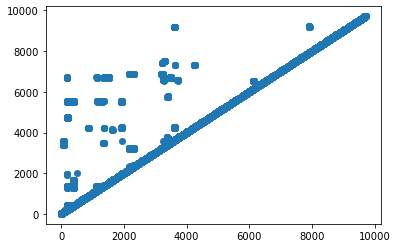

In [23]:
plt.scatter(pair_idx_0, pair_idx_1)

/home/savirlab/anaconda3/envs/nati_venv/lib/python3.6/site-packages/matplotlib/collections.py:922: RuntimeWarning:

invalid value encountered in sqrt



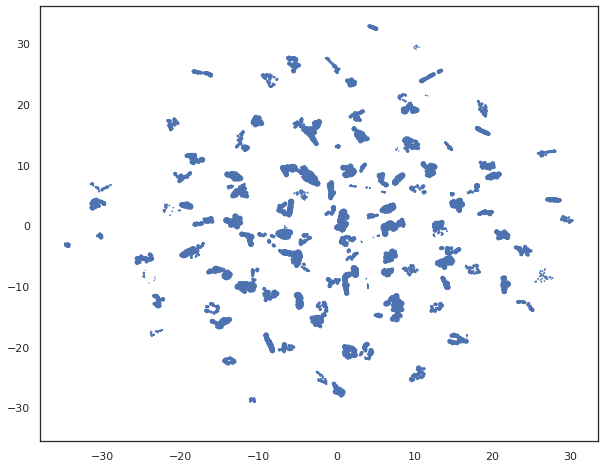

In [46]:
#TSNE
dim = 3
test_name = 'thermal_net_nv_dim_' + str(dim)
X_embedded = TSNE(n_components=dim).fit_transform(kf_embedding)

if dim == 2:
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
    data = {'Temperature':temp_list , 'patient_id':patient_id, 'patient_age':patient_age, 'patient_gender':patient_gender, 'patient_weight':patient_weight, 'patient_height':patient_height, 'x': X_embedded[:, 0], 'y': X_embedded[:, 1]}
elif dim == 3:
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2]) 
    data = {'Temperature':temp_list , 'patient_id':patient_id, 'patient_age':patient_age, 'patient_gender':patient_gender, 'patient_weight':patient_weight, 'patient_height':patient_height, 'x': X_embedded[:, 0], 'y': X_embedded[:, 1], 'z': X_embedded[:, 2]}
else:
    raise AssertionError('No support in higher dimensions here')

plt.show()

In [47]:
df = pd.DataFrame.from_dict(data)
if dim == 2:
    fig = px.scatter(df, x='x', y='y',
                          color='Temperature', color_continuous_scale='jet',
                          title='TSNE (dimension = 2) of NV features, produced by ' + test_name, hover_name=data['patient_id'])
    #fig.show()
elif dim == 3:
    fig = px.scatter_3d(df, x='x', y='y', z='z',
                          color='Temperature', color_continuous_scale='jet',
                          title='TSNE (dimension = 3) of NV features, produced by ' + test_name, hover_name=data['patient_id'])
else:
    raise AssertionError('No support in higher dimensions here')
fig.write_html(join("/home/nati/files/" + test_name + ".html"))

In [29]:
#UMAP enhanced clusterring
dim = 2
test_name = 'thermal_net_nv_umap_dim_' + str(dim)

sns.set(style='white', rc={'figure.figsize':(10,8)})
X_embedded = umap.UMAP(
n_neighbors=15,
min_dist=0.0,
n_components=2,
random_state=42,).fit_transform(kf_embedding)

In [31]:
data = {'Temperature':temp_list , 'patient_id':patient_id, 'patient_age':patient_age, 'patient_gender':patient_gender, 'patient_weight':patient_weight, 'patient_height':patient_height, 'x': X_embedded[:, 0], 'y': X_embedded[:, 1]}
df = pd.DataFrame.from_dict(data)
if dim == 2:
    fig_umap = px.scatter(df, x='x', y='y',
                          color='Temperature', color_continuous_scale='jet',
                          title='UMAP (dimension = 2) of NV features, produced by ' + test_name, hover_name=data['patient_id'])
    #fig_umap.show()

    fig_umap.write_html(join("/home/nati/files/" + test_name + ".html"))